<a href="https://colab.research.google.com/github/JYLI-at-eada/CI-CD-EXERCISE/blob/main/Final_project_Model_Selien.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# ✅ Load raw Excel
file_path = "TEST-HSTECH-10Y.xlsx"
sheet_price = pd.read_excel(file_path, sheet_name=0)
sheet_macd = pd.read_excel(file_path, sheet_name=1)
sheet_vhsi = pd.read_excel(file_path, sheet_name=2)

# ✅ Standardize column names
sheet_price = sheet_price.rename(columns={
    'DATE': 'date', 'CLOSE': 'close', 'OPEN': 'open',
    'HIGH': 'high', 'LOW': 'low', 'volume': 'volume'
})
sheet_macd = sheet_macd.rename(columns={'DATE': 'date'})
sheet_vhsi = sheet_vhsi.rename(columns={'DATE': 'date', 'CLOSE': 'vhsi'})

# ✅ Convert date to datetime
for df in [sheet_price, sheet_macd, sheet_vhsi]:
    df['date'] = pd.to_datetime(df['date']).dt.normalize()

# ✅ Convert volume string to number
def convert_volume(v):
    if isinstance(v, str):
        v = v.replace(",", "").strip()
        if v.endswith('B'):
            return float(v[:-1]) * 1e9
        elif v.endswith('M'):
            return float(v[:-1]) * 1e6
    return pd.to_numeric(v, errors='coerce')

sheet_price['volume'] = sheet_price['volume'].apply(convert_volume)

# ✅ Merge tables（以日线为主表）
merged = sheet_price.merge(sheet_macd, on='date', how='left')
merged = merged.merge(sheet_vhsi[['date', 'vhsi']], on='date', how='left')
merged = merged.sort_values(by='date').reset_index(drop=True)
print("✅ 合并行数：", len(merged))

# ✅ Calculate RSI
def calculate_rsi(series, window=9):
    delta = series.diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / (avg_loss + 1e-10)
    return 100 - (100 / (1 + rs))

merged['rsi'] = calculate_rsi(merged['close'])

# ✅ Compute future 3-day drawdown
future_close = pd.concat([
    merged['close'].shift(-1),
    merged['close'].shift(-2),
    merged['close'].shift(-3)
], axis=1)
merged['future_min_close_3d'] = future_close.min(axis=1)
merged['drawdown_3d'] = (merged['future_min_close_3d'] - merged['close']) / merged['close']

# ✅ Generate sell label
merged['sell_label'] = (merged['drawdown_3d'] < -0.05).astype(int)


# ✅ Save
merged.to_csv("merged_10Y_dataset.csv", index=False)
merged.to_csv("merged_with_label.csv", index=False)

# ✅ 简要查看 tail
print("✅ Preview:")
print(merged[['date', 'close', 'rsi', 'vhsi', 'drawdown_3d', 'sell_label']].tail(5))

# ================================
# ✅ Model training prep section
# ================================

# ✅ Reload latest
merged = pd.read_csv("merged_with_label.csv")

# ✅ Fill missing MACD / Signal
merged['MACD_1Y'] = merged['MACD_1Y'].fillna(0)
merged['Signal_1Y'] = merged['Signal_1Y'].fillna(0)

# ✅ Features to use
features = [
    'rsi', 'vhsi', 'MACD_1Y', 'Signal_1Y',
'open', 'high', 'low', 'close', 'volume'
]

# ✅ Drop rows only if label-related columns missing
essential = ['rsi', 'vhsi', 'drawdown_3d', 'sell_label']
merged = merged.dropna(subset=essential)

# ✅ build training set
X = merged[features].copy()
y = merged['sell_label'].copy()

# ✅ Summary
print("✅ Feature matrix shape:", X.shape)
print("✅ Number of sell signals:", y.sum())
print("✅ Total number of samples:", len(y))


✅ 合并行数： 2467
✅ Preview:
           date    close        rsi   vhsi  drawdown_3d  sell_label
2462 2025-03-06  6068.77  57.663181  28.86    -0.030201           0
2463 2025-03-07  6037.44  59.332370  28.72    -0.031815           0
2464 2025-03-10  5885.49  56.717019  27.61    -0.006818           0
2465 2025-03-11  5967.23  50.552495  27.66    -0.020423           0
2466 2025-03-12  5845.36  48.591343  27.16          NaN           0
✅ Feature matrix shape: (2458, 9)
✅ Number of sell signals: 225
✅ Total number of samples: 2458


In [ ]:
# ✅ Define a quick column summary function
def show_column_summary(df, col, threshold=None, condition_label=None):
    print(f"\n✅ Distribution of '{col}':")
    print(df[col].describe())

    if threshold is not None and condition_label:
        if condition_label == '>':
            count = (df[col] > threshold).sum()
        elif condition_label == '<':
            count = (df[col] < threshold).sum()
        else:
            raise ValueError("Condition must be '>' or '<'")
        print(f"Number of rows where {col} {condition_label} {threshold}: {count}")

    print(f"Number of missing values in '{col}': {df[col].isna().sum()}")

# ✅ General dataset overview
print("✅ Total number of samples:", len(merged))

# ✅ Summary for RSI
show_column_summary(merged, 'rsi', threshold=70, condition_label='>')

# ✅ Summary for 3-day drawdown
show_column_summary(merged, 'drawdown_3d', threshold=-0.05, condition_label='<')

# ✅ Summary for VHSI
show_column_summary(merged, 'vhsi', threshold=20, condition_label='>')

# ✅ Sell label distribution
print("\n✅ Number of samples with sell_label = 1:", merged['sell_label'].sum())


✅ Total number of samples: 2458

✅ Distribution of 'rsi':
count    2458.000000
mean       51.468169
std        20.888940
min         0.632151
25%        36.640144
50%        51.668486
75%        66.661668
max       100.000000
Name: rsi, dtype: float64
Number of rows where rsi > 70: 497
Number of missing values in 'rsi': 0

✅ Distribution of 'drawdown_3d':
count    2458.000000
mean       -0.013126
std         0.029591
min        -0.217333
25%        -0.028400
50%        -0.010659
75%         0.004754
max         0.222027
Name: drawdown_3d, dtype: float64
Number of rows where drawdown_3d < -0.05: 225
Number of missing values in 'drawdown_3d': 0

✅ Distribution of 'vhsi':
count    2458.000000
mean       22.062587
std         5.954939
min        11.360000
25%        18.140000
50%        21.490000
75%        24.955000
max        64.800000
Name: vhsi, dtype: float64
Number of rows where vhsi > 20: 1511
Number of missing values in 'vhsi': 0

✅ Number of samples with sell_label = 1: 225


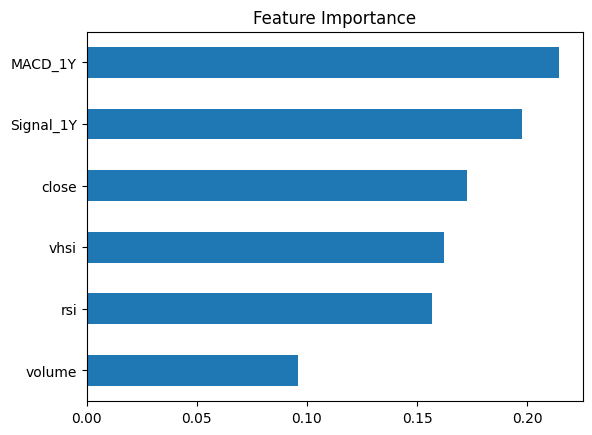

In [ ]:
# 设定 X 和 y
# ✅ 设定 X 和 y（使用正确字段名）
X = merged[['rsi', 'vhsi', 'MACD_1Y', 'Signal_1Y', 'close', 'volume']]
y = merged['sell_label']


# 拆分训练集、测试集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 用一个模型训练
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train, y_train)

# 查看特征重要性
import matplotlib.pyplot as plt
import pandas as pd
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.sort_values().plot(kind='barh')
plt.title("Feature Importance")
plt.show()


In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_text

# 训练一个简单的单棵树，用来可视化规则（方便理解，不用于回测）
tree_model = DecisionTreeClassifier(max_depth=4, random_state=42)
tree_model.fit(X_train, y_train)

# 输出规则
rules = export_text(tree_model, feature_names=list(X_train.columns))
print(rules)


|--- MACD_1Y <= 1511.44
|   |--- MACD_1Y <= -738.20
|   |   |--- rsi <= 23.57
|   |   |   |--- MACD_1Y <= -1109.73
|   |   |   |   |--- class: 0
|   |   |   |--- MACD_1Y >  -1109.73
|   |   |   |   |--- class: 1
|   |   |--- rsi >  23.57
|   |   |   |--- MACD_1Y <= -762.45
|   |   |   |   |--- class: 0
|   |   |   |--- MACD_1Y >  -762.45
|   |   |   |   |--- class: 0
|   |--- MACD_1Y >  -738.20
|   |   |--- vhsi <= 19.69
|   |   |   |--- rsi <= 39.61
|   |   |   |   |--- class: 0
|   |   |   |--- rsi >  39.61
|   |   |   |   |--- class: 0
|   |   |--- vhsi >  19.69
|   |   |   |--- vhsi <= 19.80
|   |   |   |   |--- class: 0
|   |   |   |--- vhsi >  19.80
|   |   |   |   |--- class: 0
|--- MACD_1Y >  1511.44
|   |--- Signal_1Y <= 1262.58
|   |   |--- class: 0
|   |--- Signal_1Y >  1262.58
|   |   |--- volume <= 1195000000.00
|   |   |   |--- class: 1
|   |   |--- volume >  1195000000.00
|   |   |   |--- class: 0



In [ ]:
df = pd.read_csv("merged_with_label.csv")  # 或者重新指定路径

print(df.columns.tolist())  # 确认字段里是否有 sell_label

print(df['sell_label'].value_counts())     # 如果有就打印正负类数量


['date', 'close', 'open', 'high', 'low', 'volume', 'CHANGE', 'Unnamed: 7', 'Unnamed: 8', 'CLOSE', 'MACD_1M', 'Signal_1M', 'MACD_3M', 'Signal_3M', 'MACD_6M', 'Signal_6M', 'MACD_1Y', 'Signal_1Y', 'vhsi', 'rsi', 'future_min_close_3d', 'drawdown_3d', 'sell_label']
sell_label
0    2242
1     225
Name: count, dtype: int64


In [ ]:
###平衡法1
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report

# ✅ 读取数据
df = pd.read_csv("merged_with_label.csv")

# ✅ 填充空值（你原来用过）
df['MACD_1Y'] = df['MACD_1Y'].fillna(0)
df['Signal_1Y'] = df['Signal_1Y'].fillna(0)

# ✅ 特征与标签
features = ['rsi', 'vhsi', 'MACD_1Y', 'Signal_1Y',
            'open', 'high', 'low', 'close', 'volume']
df = df.dropna(subset=features + ['sell_label'])

X = df[features]
y = df['sell_label']

# ✅ 1. 先切分训练集与测试集（注意在这一步前都不能动数据）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# ✅ 2. 仅对训练集做上采样
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# ✅ 3. 模型训练（使用上采样后的训练集）
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_resampled, y_resampled)

# ✅ 4. 模型预测 + 评估
y_pred = model.predict(X_test)
print("\n✅ Classification Report:")
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:18:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



✅ Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94       176
           1       0.53      0.33      0.41        24

    accuracy                           0.89       200
   macro avg       0.72      0.65      0.67       200
weighted avg       0.87      0.89      0.87       200



加强

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split


In [ ]:
##平衡法2
!pip install lightgbm


In [ ]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# 读取数据
df = pd.read_csv("merged_with_label.csv")

# 填充缺失值
df['MACD_1Y'] = df['MACD_1Y'].fillna(0)
df['Signal_1Y'] = df['Signal_1Y'].fillna(0)

# 特征与标签列
features = ['rsi', 'vhsi', 'MACD_1Y', 'Signal_1Y', 'open', 'high', 'low', 'close', 'volume']
label_col = 'sell_label'

# 删除缺失
df = df.dropna(subset=features + [label_col])

# ✅ ✅ ✅ 保留日期字段
X = df[features]
y = df[label_col]
dates = df['date']  # 👈 添加这行

# 样本权重
weights = y.apply(lambda x: 10 if x == 1 else 1)

# ✅ ✅ ✅ 切分数据时同时切 dates
X_train, X_test, y_train, y_test, w_train, w_test, date_train, date_test = train_test_split(
    X, y, weights, dates, test_size=0.2, random_state=42
)

# 训练 LightGBM
train_data = lgb.Dataset(X_train, label=y_train, weight=w_train)
test_data = lgb.Dataset(X_test, label=y_test, weight=w_test, reference=train_data)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': 1,
    'boosting_type': 'gbdt',
    'random_state': 42
}

model = lgb.train(params, train_data, valid_sets=[test_data])

# 预测
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred))

# ✅ ✅ ✅ 构建结果 DataFrame（用切分出的 date_test）
result_df = X_test.copy()
result_df['date'] = date_test.values  # 👈 正确方式：来自 train_test_split
result_df['sell_prob'] = y_pred_prob
result_df['sell_label_pred'] = y_pred
result_df['sell_label_true'] = y_test.values



# 保存预测结果
result_df.to_csv("predictions_with_prob_and_label.csv", index=False)


[LightGBM] [Info] Number of positive: 97, number of negative: 701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 798, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.580491 -> initscore=0.324788
[LightGBM] [Info] Start training from score 0.324788
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       178
           1       0.55      0.55      0.55        22

    accuracy                           0.90       200
   macro avg       0.74      0.74      0.74       200
weighted avg       

In [ ]:
print(df.columns.tolist())  # 看看所有列名
print(df.head(3))           # 打印前三行看看数据


['date', 'close', 'open', 'high', 'low', 'volume', 'CHANGE', 'Unnamed: 7', 'Unnamed: 8', 'CLOSE', 'MACD_1M', 'Signal_1M', 'MACD_3M', 'Signal_3M', 'MACD_6M', 'Signal_6M', 'MACD_1Y', 'Signal_1Y', 'vhsi', 'rsi', 'future_min_close_3d', 'drawdown_3d', 'sell_label']
            date     close      open      high       low        volume  \
1468  2021-02-16  10694.68  10620.97  10785.98  10585.65  7.859400e+08   
1469  2021-02-17  10945.22  10658.24  10945.22  10555.63  7.924000e+08   
1470  2021-02-18  10591.53  10964.67  11001.78  10565.40  1.020000e+09   

      CHANGE  Unnamed: 7 Unnamed: 8     CLOSE  ...   Signal_3M      MACD_6M  \
1468  0.0272         NaN        NaN  10694.68  ...  371.723552  1181.037551   
1469  0.0234         NaN        NaN  10945.22  ...  386.672935  1231.119526   
1470 -0.0323         NaN        NaN  10591.53  ...  398.633518  1254.355168   

       Signal_6M      MACD_1Y    Signal_1Y   vhsi        rsi  \
1468  933.996696  1566.711257  1255.749485  22.06  77.864647 

In [ ]:
df = pd.read_csv("predictions_with_prob_and_label.csv")

def sell_strategy(prob):
    if prob > 0.9:
        return "🔥 Sell All"
    elif prob > 0.7:
        return "⚠️ Sell Partially"
    elif prob < 0.6:
        return "✅ Hold"
    else:
        return "🤔 Uncertain"

df['sell_suggestion'] = df['sell_prob'].apply(sell_strategy)
print(df[['date', 'sell_prob', 'sell_suggestion']].tail(10))


           date  sell_prob sell_suggestion
190  2024-04-08   0.000794          ✅ Hold
191  2024-06-11   0.004569          ✅ Hold
192  2022-06-23   0.044217          ✅ Hold
193  2022-01-28   0.001435          ✅ Hold
194  2022-07-15   0.005444          ✅ Hold
195  2021-06-10   0.002120          ✅ Hold
196  2021-03-29   0.001077          ✅ Hold
197  2022-03-30   0.091934          ✅ Hold
198  2022-03-08   0.984629      🔥 Sell All
199  2022-11-03   0.244749          ✅ Hold


回测

In [ ]:
# ✅ Step 1：读取数据
df = pd.read_csv("merged_10Y_dataset.csv").dropna().reset_index(drop=True)

# ✅ Step 2：准备特征
features = ['rsi', 'vhsi', 'MACD_1Y', 'Signal_1Y', 'open', 'high', 'low', 'close', 'volume']
df[features] = df[features].fillna(0)  # 保证无缺值

# ✅ Step 3：打标签（预测概率）
df['sell_prob'] = model.predict(df[features].values)  # ← 转成 numpy array ✅✅✅

# ✅ Step 4：保存结果
df.to_csv("merged_with_sell_prob.csv", index=False)
print("✅ 标签生成完毕，文件已保存为 merged_with_sell_prob.csv")

✅ 标签生成完毕，文件已保存为 merged_with_sell_prob.csv


In [ ]:
print(len(merged))  # 看看总共有多少行


2458


In [ ]:
# ✅ 从原始10年数据开始
df = pd.read_csv("merged_10Y_dataset.csv").reset_index(drop=True)

# ✅ 特征与模型保持一致
features = ['rsi', 'vhsi', 'MACD_1Y', 'Signal_1Y', 'open', 'high', 'low', 'close', 'volume']
df[features] = df[features].fillna(0)  # 仅填特征列，不全表删

# ✅ 打标签（模型已训练）
df['sell_prob'] = model.predict(df[features].values)

# ✅ 保存新表用于回测
df.to_csv("merged_10Y_with_sell_prob.csv", index=False)
print("✅ 回测数据已准备完毕，行数：", df.shape[0])


✅ 回测数据已准备完毕，行数： 2467


In [ ]:
print(df.isna().sum())  # 检查是不是还有关键列有NaN
print(df.shape)         # 行数应该是 2000+ 才对
print(df.head())        # 确保 sell_prob 已生成


date                      0
close                     0
open                      0
high                      0
low                       0
volume                    0
CHANGE                    0
Unnamed: 7             2467
Unnamed: 8             2464
CLOSE                     0
MACD_1M                   0
Signal_1M                 0
MACD_3M                   0
Signal_3M                 0
MACD_6M                   0
Signal_6M                 0
MACD_1Y                   0
Signal_1Y                 0
vhsi                      0
rsi                       0
future_min_close_3d       1
drawdown_3d               1
sell_label                0
sell_prob                 0
dtype: int64
(2467, 24)
         date    close     open     high      low  volume  CHANGE  Unnamed: 7  \
0  2015-03-02  3210.65  3210.65  3210.65  3210.65     0.0  0.0030         NaN   
1  2015-03-03  3194.35  3194.35  3194.35  3194.35     0.0 -0.0051         NaN   
2  2015-03-04  3224.50  3224.50  3224.50  3224.50     0.0  0.

In [ ]:
# ✅ 清除 CSV 导入时多出的无效列
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# ✅ 预测打标签（前提是模型已经训练完）
features = ['rsi', 'vhsi', 'MACD_1Y', 'Signal_1Y', 'open', 'high', 'low', 'close', 'volume']
df['sell_prob'] = model.predict(df[features].values)

# ✅ 保存为用于回测的新文件
df.to_csv("merged_10Y_with_sell_prob.csv", index=False)
print("✅ 成功生成 sell_prob，新文件行数：", df.shape[0])


✅ 成功生成 sell_prob，新文件行数： 2467


<ipython-input-31-2944397462>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sell_prob'] = model.predict(df[features].values)


In [ ]:
merged = pd.read_csv("merged_10Y_with_sell_prob.csv")
print("✅ 回测数据读取成功，行数：", merged.shape[0])


✅ 回测数据读取成功，行数： 2467


In [ ]:
import pandas as pd

# ✅ Step 1: 计算 RSI 指标
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0).rolling(window=period).mean()
    loss = -delta.clip(upper=0).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# ✅ Step 2: 读取并预处理数据
merged = pd.read_csv("merged_10Y_with_sell_prob.csv")  # ← 使用你刚生成的文件
merged['date'] = pd.to_datetime(merged['date'], errors='coerce')
merged = merged.sort_values(by='date').reset_index(drop=True)

# ✅ Step 3: 指标补充 + 缺失填补
merged['RSI'] = calculate_rsi(merged['close'])
merged['sell_prob'] = merged['sell_prob'].fillna(0)

# ✅ Step 4: 只保留用于回测的字段（可按需加 VHSI 等）
merged = merged[['date', 'close', 'MACD_1Y', 'Signal_1Y', 'sell_prob', 'RSI']].dropna().reset_index(drop=True)

# ✅ Step 5: 判断金叉（MACD 上穿 Signal）
def is_macd_golden_cross(df):
    return (df['MACD_1Y'].shift(1) <= df['Signal_1Y'].shift(1)) & (df['MACD_1Y'] > df['Signal_1Y'])

merged['golden_cross'] = is_macd_golden_cross(merged)
merged['buy_signal'] = merged['golden_cross']

# ✅ Step 6: 策略 A — 分批买入 + 分级卖出
def backtest_strategy_a(df):
    capital = 100.0
    position = 0.0
    logs = []
    buy_count = 0
    sell_count = 0

    for i in range(1, len(df)):
        today = df.iloc[i]

        # ⬆️ 买入逻辑
        if today['buy_signal']:
            if position == 0:
                amount = 0.5 * capital / today['close']
                capital -= amount * today['close']
                position += amount
                logs.append((today['date'], 'Initial Buy 50%', capital + position * today['close']))
                buy_count += 1
            elif capital > 0:
                amount = 0.8 * capital / today['close']
                capital -= amount * today['close']
                position += amount
                logs.append((today['date'], 'Add Buy 80%', capital + position * today['close']))
                buy_count += 1

        # ⬇️ 卖出逻辑
        if today['sell_prob'] > 0.9 and position > 0:
            sell_amt = position * 0.5
            capital += sell_amt * today['close']
            position -= sell_amt
            logs.append((today['date'], 'Strong Sell 50%', capital + position * today['close']))
            sell_count += 1
        elif 0.7 < today['sell_prob'] <= 0.9 and position > 0:
            sell_amt = position * 0.3
            capital += sell_amt * today['close']
            position -= sell_amt
            logs.append((today['date'], 'Partial Sell 30%', capital + position * today['close']))
            sell_count += 1

    final_val = round(capital + position * df.iloc[-1]['close'], 2)
    log_df = pd.DataFrame(logs, columns=["Date", "Action", "NetValue"])
    #return final_val, log_df, len(logs), buy_count, sell_count
    return final_val, pd.DataFrame(logs, columns=["date", "action", "value"]), len(logs), buy_count, sell_count


# ✅ Step 7: 策略 B — 首次金叉买入，长期持有
def backtest_strategy_b(df):
    capital = 100.0
    position = 0.0
    for i in range(1, len(df)):
        today = df.iloc[i]
        if today['golden_cross']:
            position = capital / today['close']
            capital = 0.0
            break
    if position == 0:
        return capital
    return round(capital + position * df.iloc[-1]['close'], 2)

# ✅ Step 8: 多周期切片回测
periods = [252, 252*3, 252*5, 252*10]
labels = ['1Y', '3Y', '5Y', '10Y']
results = []

for period, label in zip(periods, labels):
    sub_df = merged.tail(period).reset_index(drop=True) if period <= len(merged) else merged.copy()
    if len(sub_df) == 0:
        print(f"⚠️ 数据不足，跳过 {label} 回测")
        continue

    print(f"\n⏳ Backtesting period: {label}, Data points: {len(sub_df)}")
    a_val, a_logs, total_ops, buy_ops, sell_ops = backtest_strategy_a(sub_df)
    b_val = backtest_strategy_b(sub_df)

    print(f"💰 Strategy A final value: {a_val:.2f}")
    print(f"💰 Strategy B final value: {b_val:.2f}")
    print(f"📊 Total operations: {total_ops}, Buys: {buy_ops}, Sells: {sell_ops}")

    # 可选：保存每轮操作日志
    a_logs.to_csv(f"strategyA_log_{label}.csv", index=False)

    results.append({
        "Period": label,
        "Data Points": len(sub_df),
        "Strategy A Value": a_val,
        "Strategy B Value": b_val,
        "Operations": total_ops,
        "Buy Count": buy_ops,
        "Sell Count": sell_ops,
    })



# ✅ Step 9: 汇总结果打印
print("\n📊 回测结果汇总：")
for r in results:
    print(f"{r['Period']} | A: {r['Strategy A Value']} | B: {r['Strategy B Value']} | Buys: {r['Buy Count']} | Sells: {r['Sell Count']}")

# ✅ Step 10: 美化成 DataFrame 表格
summary_df = pd.DataFrame(results)

summary_df["Strategy A Return"] = (summary_df["Strategy A Value"] - 100) / 100
summary_df["Strategy B Return"] = (summary_df["Strategy B Value"] - 100) / 100
summary_df["Excess Return"] = summary_df["Strategy A Return"] - summary_df["Strategy B Return"]
summary_df["Strategy A CAGR"] = (summary_df["Strategy A Value"] / 100) ** (1 / summary_df["Period"].str.replace("Y", "").astype(int)) - 1
summary_df["Strategy B CAGR"] = (summary_df["Strategy B Value"] / 100) ** (1 / summary_df["Period"].str.replace("Y", "").astype(int)) - 1

styled = (
    summary_df[
        [
            "Period",
            "Strategy A Value",
            "Strategy B Value",
            "Strategy A Return",
            "Strategy B Return",
            "Strategy A CAGR",
            "Strategy B CAGR",
            "Excess Return",
            "Operations",
            "Buy Count",
            "Sell Count",
        ]
    ]
    .rename(
        columns={
            "Strategy A Value": "A Net Value",
            "Strategy B Value": "B Net Value",
            "Strategy A Return": "A Return",
            "Strategy B Return": "B Return",
            "Strategy A CAGR": "A CAGR",
            "Strategy B CAGR": "B CAGR",
            "Excess Return": "Excess Return",
            "Operations": "A Operation Count",
            "Buy Count": "A Buy Count",
            "Sell Count": "A Sell Count",
        }
    )
    .style.format(
        {
            "A Net Value": "{:.2f}",
            "B Net Value": "{:.2f}",
            "A Return": "{:.2%}",
            "B Return": "{:.2%}",
            "A CAGR": "{:.2%}",
            "B CAGR": "{:.2%}",
            "Excess Return": "{:.2%}",
        }
    )
    .set_caption("📊 回测结果汇总：Strategy A vs Strategy B")
)

styled




⏳ Backtesting period: 1Y, Data points: 252
💰 Strategy A final value: 155.39
💰 Strategy B final value: 162.20
📊 Total operations: 13, Buys: 3, Sells: 10

⏳ Backtesting period: 3Y, Data points: 756
💰 Strategy A final value: 184.03
💰 Strategy B final value: 132.92
📊 Total operations: 60, Buys: 7, Sells: 53

⏳ Backtesting period: 5Y, Data points: 1260
💰 Strategy A final value: 284.37
💰 Strategy B final value: 108.60
📊 Total operations: 122, Buys: 11, Sells: 111

⏳ Backtesting period: 10Y, Data points: 2453
💰 Strategy A final value: 563.37
💰 Strategy B final value: 174.45
📊 Total operations: 129, Buys: 18, Sells: 111

📊 回测结果汇总：
1Y | A: 155.39 | B: 162.2 | Buys: 3 | Sells: 10
3Y | A: 184.03 | B: 132.92 | Buys: 7 | Sells: 53
5Y | A: 284.37 | B: 108.6 | Buys: 11 | Sells: 111
10Y | A: 563.37 | B: 174.45 | Buys: 18 | Sells: 111


,Period,A Net Value,B Net Value,A Return,B Return,A CAGR,B CAGR,Excess Return,A Operation Count,A Buy Count,A Sell Count
0,1Y,155.39,162.20,55.39%,62.20%,55.39%,62.20%,-6.81%,13,3,10
1,3Y,184.03,132.92,84.03%,32.92%,22.55%,9.95%,51.11%,60,7,53
2,5Y,284.37,108.60,184.37%,8.60%,23.25%,1.66%,175.77%,122,11,111
3,10Y,563.37,174.45,463.37%,74.45%,18.87%,5.72%,388.92%,129,18,111


<ipython-input-53-2504963090>:120: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


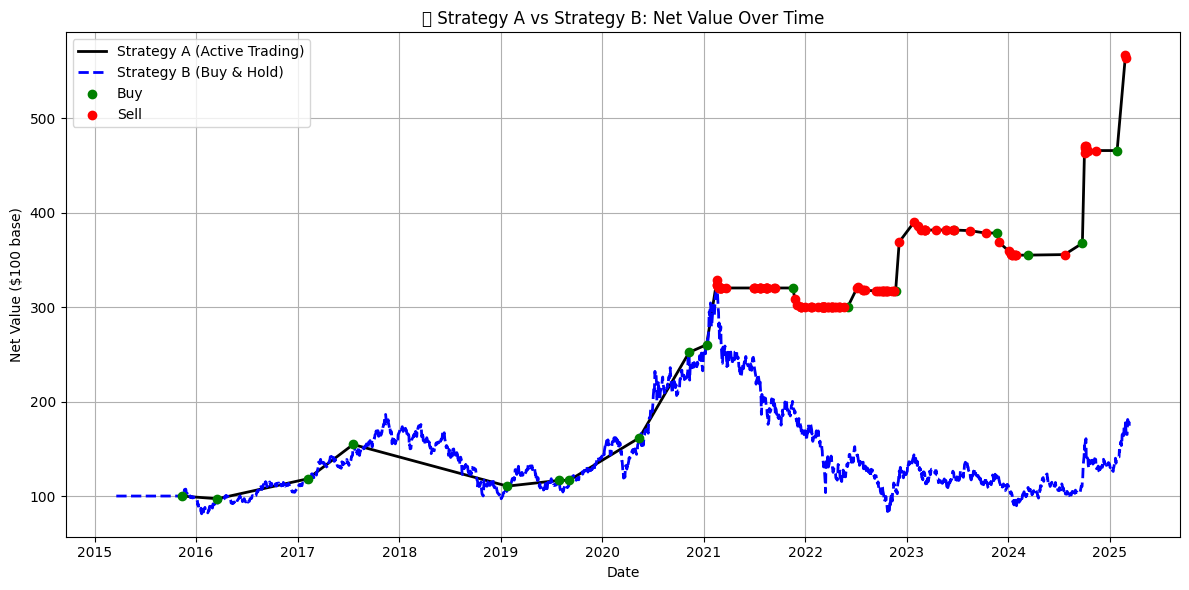

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ✅ 计算 RSI 指标
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0).rolling(window=period).mean()
    loss = -delta.clip(upper=0).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# ✅ 读取数据
merged = pd.read_csv("merged_10Y_with_sell_prob.csv")  # ⬅️ 改成你本地的路径
merged['date'] = pd.to_datetime(merged['date'], errors='coerce')
merged = merged.sort_values(by='date').reset_index(drop=True)
merged['RSI'] = calculate_rsi(merged['close'])
merged['sell_prob'] = merged['sell_prob'].fillna(0)
merged = merged[['date', 'close', 'MACD_1Y', 'Signal_1Y', 'sell_prob', 'RSI']].dropna().reset_index(drop=True)

# ✅ 判断金叉
def is_macd_golden_cross(df):
    return (df['MACD_1Y'].shift(1) <= df['Signal_1Y'].shift(1)) & (df['MACD_1Y'] > df['Signal_1Y'])

merged['golden_cross'] = is_macd_golden_cross(merged)
merged['buy_signal'] = merged['golden_cross']

# ✅ 策略 A 回测（不变）
def backtest_strategy_a(df):
    capital = 100.0
    position = 0.0
    logs = []
    buy_count = 0
    sell_count = 0

    for i in range(1, len(df)):
        today = df.iloc[i]
        if today['buy_signal']:
            if position == 0:
                amount = 0.5 * capital / today['close']
                capital -= amount * today['close']
                position += amount
                logs.append((today['date'], 'Initial Buy 50%', capital + position * today['close']))
                buy_count += 1
            elif capital > 0:
                amount = 0.8 * capital / today['close']
                capital -= amount * today['close']
                position += amount
                logs.append((today['date'], 'Add Buy 80%', capital + position * today['close']))
                buy_count += 1
        if today['sell_prob'] > 0.9 and position > 0:
            sell_amt = position * 0.5
            capital += sell_amt * today['close']
            position -= sell_amt
            logs.append((today['date'], 'Strong Sell 50%', capital + position * today['close']))
            sell_count += 1
        elif 0.7 < today['sell_prob'] <= 0.9 and position > 0:
            sell_amt = position * 0.3
            capital += sell_amt * today['close']
            position -= sell_amt
            logs.append((today['date'], 'Partial Sell 30%', capital + position * today['close']))
            sell_count += 1

    final_val = round(capital + position * df.iloc[-1]['close'], 2)
    log_df = pd.DataFrame(logs, columns=["date", "action", "NetValue"])
    return final_val, log_df, len(logs), buy_count, sell_count

# ✅ 策略 B 回测（动态曲线）
def backtest_strategy_b_curve(df):
    capital = 100.0
    position = 0.0
    buy_index = None

    for i in range(1, len(df)):
        if df.iloc[i]['golden_cross']:
            buy_index = i
            buy_price = df.iloc[i]['close']
            position = capital / buy_price
            break

    # 没买入则净值恒为 100
    if buy_index is None:
        return pd.Series([100.0] * len(df), index=df.index)

    # 有买入，从买入日开始变动
    b_curve = [100.0] * buy_index
    for i in range(buy_index, len(df)):
        price = df.iloc[i]['close']
        net_value = round(position * price, 2)
        b_curve.append(net_value)

    return pd.Series(b_curve, index=df.index)

# ✅ 执行回测（以10年为例）
sub_df = merged.tail(252*10).reset_index(drop=True)
a_val, a_logs_df, _, _, _ = backtest_strategy_a(sub_df)
b_curve = backtest_strategy_b_curve(sub_df)

# ✅ 绘图
plt.figure(figsize=(12, 6))

# 策略 A：主动交易轨迹
plt.plot(a_logs_df['date'], a_logs_df['NetValue'], color='black', label='Strategy A (Active Trading)', linewidth=2)

# 策略 B：跟随市场变化
plt.plot(sub_df['date'], b_curve, linestyle='--', color='blue', label='Strategy B (Buy & Hold)', linewidth=2)

# 买卖点
buy_points = a_logs_df[a_logs_df['action'].str.contains("Buy")]
sell_points = a_logs_df[a_logs_df['action'].str.contains("Sell")]
plt.scatter(buy_points['date'], buy_points['NetValue'], color='green', label='Buy', zorder=5)
plt.scatter(sell_points['date'], sell_points['NetValue'], color='red', label='Sell', zorder=5)

# 图形美化
plt.title("📈 Strategy A vs Strategy B: Net Value Over Time")
plt.xlabel("Date")
plt.ylabel("Net Value ($100 base)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


<ipython-input-47-2641679915>:27: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


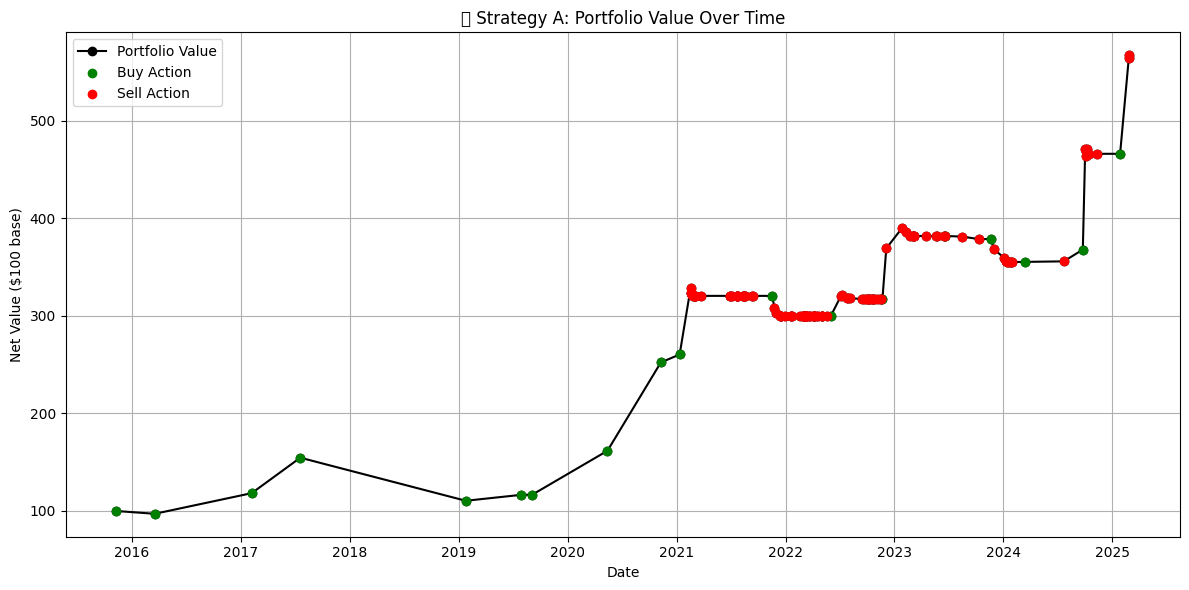

In [ ]:
import matplotlib.pyplot as plt

# 用完整的带列名 logs（即 a_logs）作图
log_df = a_logs.copy()

if log_df.empty:
    print("⚠️ No trades found.")
else:
    # 确保 date 是 datetime 类型
    log_df['date'] = pd.to_datetime(log_df['date'])

    # 分开买卖点
    buy_points = log_df[log_df['action'].str.contains("Buy")]
    sell_points = log_df[log_df['action'].str.contains("Sell")]

    # 作图
    plt.figure(figsize=(12, 6))
    plt.plot(log_df['date'], log_df['value'], marker='o', linestyle='-', color='black', label='Portfolio Value')
    plt.scatter(buy_points['date'], buy_points['value'], color='green', label='Buy Action', zorder=5)
    plt.scatter(sell_points['date'], sell_points['value'], color='red', label='Sell Action', zorder=5)

    plt.title('📈 Strategy A: Portfolio Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Net Value ($100 base)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


Training

⭐**PART 1: Data Preprocessing and Training Preparation**

In [ ]:
import pandas as pd

# ✅ Load raw Excel
file_path = "TEST-HSTECH-10Y.xlsx"
sheet_price = pd.read_excel(file_path, sheet_name=0)
sheet_macd = pd.read_excel(file_path, sheet_name=1)
sheet_vhsi = pd.read_excel(file_path, sheet_name=2)

# ✅ Standardize column names
sheet_price = sheet_price.rename(columns={
    'DATE': 'date', 'CLOSE': 'close', 'OPEN': 'open',
    'HIGH': 'high', 'LOW': 'low', 'volume': 'volume'
})
sheet_macd = sheet_macd.rename(columns={'DATE': 'date'})
sheet_vhsi = sheet_vhsi.rename(columns={'DATE': 'date', 'CLOSE': 'vhsi'})

# ✅ Convert date to datetime
for df in [sheet_price, sheet_macd, sheet_vhsi]:
    df['date'] = pd.to_datetime(df['date']).dt.normalize()

# ✅ Convert volume string to number
def convert_volume(v):
    if isinstance(v, str):
        v = v.replace(",", "").strip()
        if v.endswith('B'):
            return float(v[:-1]) * 1e9
        elif v.endswith('M'):
            return float(v[:-1]) * 1e6
    return pd.to_numeric(v, errors='coerce')

sheet_price['volume'] = sheet_price['volume'].apply(convert_volume)

# ✅ Merge tables（以日线为主表）
merged = sheet_price.merge(sheet_macd, on='date', how='left')
merged = merged.merge(sheet_vhsi[['date', 'vhsi']], on='date', how='left')
merged = merged.sort_values(by='date').reset_index(drop=True)
print("✅ 合并行数：", len(merged))

# ✅ Calculate RSI
def calculate_rsi(series, window=9):
    delta = series.diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / (avg_loss + 1e-10)
    return 100 - (100 / (1 + rs))

merged['rsi'] = calculate_rsi(merged['close'])

# ✅ Compute future 3-day drawdown
future_close = pd.concat([
    merged['close'].shift(-1),
    merged['close'].shift(-2),
    merged['close'].shift(-3)
], axis=1)
merged['future_min_close_3d'] = future_close.min(axis=1)
merged['drawdown_3d'] = (merged['future_min_close_3d'] - merged['close']) / merged['close']

# ✅ Generate sell label
merged['sell_label'] = (
    (merged['drawdown_3d'] < -0.05) &
    (merged['rsi'] > 70) &
    (merged['vhsi'] > 20)
).astype(int)

# ✅ Save
merged.to_csv("merged_10Y_dataset.csv", index=False)
merged.to_csv("merged_with_label.csv", index=False)

# ✅ 简要查看 tail
print("✅ Preview:")
print(merged[['date', 'close', 'rsi', 'vhsi', 'drawdown_3d', 'sell_label']].tail(5))

# ================================
# ✅ Model training prep section
# ================================

# ✅ Reload latest
merged = pd.read_csv("merged_with_label.csv")

# ✅ Fill missing MACD / Signal
merged['MACD_1Y'] = merged['MACD_1Y'].fillna(0)
merged['Signal_1Y'] = merged['Signal_1Y'].fillna(0)

# ✅ Features to use
features = [
    'rsi', 'vhsi', 'MACD_1Y', 'Signal_1Y',
'open', 'high', 'low', 'close', 'volume'
]

# ✅ Drop rows only if label-related columns missing
essential = ['rsi', 'vhsi', 'drawdown_3d', 'sell_label']
merged = merged.dropna(subset=essential)

# ✅ build training set
X = merged[features].copy()
y = merged['sell_label'].copy()

# ✅ Summary
print("✅ Feature matrix shape:", X.shape)
print("✅ Number of sell signals:", y.sum())
print("✅ Total number of samples:", len(y))


✅ 合并行数： 2467
✅ Preview:
           date    close        rsi   vhsi  drawdown_3d  sell_label
2462 2025-03-06  6068.77  57.663181  28.86    -0.030201           0
2463 2025-03-07  6037.44  59.332370  28.72    -0.031815           0
2464 2025-03-10  5885.49  56.717019  27.61    -0.006818           0
2465 2025-03-11  5967.23  50.552495  27.66    -0.020423           0
2466 2025-03-12  5845.36  48.591343  27.16          NaN           0
✅ Feature matrix shape: (2458, 9)
✅ Number of sell signals: 30
✅ Total number of samples: 2458


Data Summary

In [ ]:
# ✅ Define a quick column summary function
def show_column_summary(df, col, threshold=None, condition_label=None):
    print(f"\n✅ Distribution of '{col}':")
    print(df[col].describe())

    if threshold is not None and condition_label:
        if condition_label == '>':
            count = (df[col] > threshold).sum()
        elif condition_label == '<':
            count = (df[col] < threshold).sum()
        else:
            raise ValueError("Condition must be '>' or '<'")
        print(f"Number of rows where {col} {condition_label} {threshold}: {count}")

    print(f"Number of missing values in '{col}': {df[col].isna().sum()}")

# ✅ General dataset overview
print("✅ Total number of samples:", len(merged))

# ✅ Summary for RSI
show_column_summary(merged, 'rsi', threshold=70, condition_label='>')

# ✅ Summary for 3-day drawdown
show_column_summary(merged, 'drawdown_3d', threshold=-0.05, condition_label='<')

# ✅ Summary for VHSI
show_column_summary(merged, 'vhsi', threshold=20, condition_label='>')

# ✅ Sell label distribution
print("\n✅ Number of samples with sell_label = 1:", merged['sell_label'].sum())


✅ Total number of samples: 2458

✅ Distribution of 'rsi':
count    2458.000000
mean       51.468169
std        20.888940
min         0.632151
25%        36.640144
50%        51.668486
75%        66.661668
max       100.000000
Name: rsi, dtype: float64
Number of rows where rsi > 70: 497
Number of missing values in 'rsi': 0

✅ Distribution of 'drawdown_3d':
count    2458.000000
mean       -0.013126
std         0.029591
min        -0.217333
25%        -0.028400
50%        -0.010659
75%         0.004754
max         0.222027
Name: drawdown_3d, dtype: float64
Number of rows where drawdown_3d < -0.05: 225
Number of missing values in 'drawdown_3d': 0

✅ Distribution of 'vhsi':
count    2458.000000
mean       22.062587
std         5.954939
min        11.360000
25%        18.140000
50%        21.490000
75%        24.955000
max        64.800000
Name: vhsi, dtype: float64
Number of rows where vhsi > 20: 1511
Number of missing values in 'vhsi': 0

✅ Number of samples with sell_label = 1: 30


 ⭐**PART 2: Upsampling to Balance Sell Label Classes**

In [ ]:
from sklearn.utils import resample
import pandas as pd

# ✅ Combine features and labels
df = X.copy()
df['sell_label'] = y

# ✅ Separate majority and minority classes
df_majority = df[df['sell_label'] == 0]
df_minority = df[df['sell_label'] == 1]

# ✅ Upsample the minority class to match the majority
df_minority_upsampled = resample(
    df_minority,
    replace=True,                 # Allow duplicates
    n_samples=len(df_majority),  # Match majority size
    random_state=42
)

# ✅ Concatenate the balanced dataset
df_balanced = pd.concat([df_majority, df_minority_upsampled])

# ✅ Split back into features and labels
X_balanced = df_balanced.drop(columns=['sell_label'])
y_balanced = df_balanced['sell_label']

# ✅ Summary after balancing
print("✅ Number of positive sell labels after balancing:", y_balanced.sum())
print("✅ Total number of balanced samples:", len(y_balanced))


✅ Number of positive sell labels after balancing: 2428
✅ Total number of balanced samples: 4856


⭐**PART 3: Train/Test Split + XGBoost Training & Evaluation**

✅ [Training Set]
Train sample count: 3884
Number of sell labels: 1942
Class distribution:
sell_label
1    0.5
0    0.5
Name: proportion, dtype: float64 

✅ [Testing Set]
Test sample count: 972
Number of sell labels: 486
Class distribution:
sell_label
0    0.5
1    0.5
Name: proportion, dtype: float64 



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:20:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 1000x600 with 0 Axes>

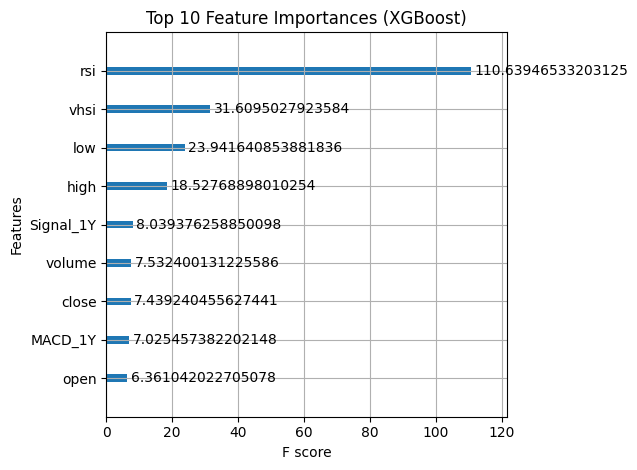

✅ Confusion Matrix:
[[481   5]
 [  0 486]]

✅ Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       486
           1       0.99      1.00      0.99       486

    accuracy                           0.99       972
   macro avg       0.99      0.99      0.99       972
weighted avg       0.99      0.99      0.99       972



In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# ✅ Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

# ✅ Print dataset summaries
def print_label_summary(y, label=""):
    print(f"{label} sample count:", len(y))
    print(f"Number of sell labels: {y.sum()}")
    print("Class distribution:")
    print(y.value_counts(normalize=True), "\n")

print("✅ [Training Set]")
print_label_summary(y_train, "Train")

print("✅ [Testing Set]")
print_label_summary(y_test, "Test")

# ✅ Initialize and train XGBoost classifier
model = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(X_train, y_train)

# ✅ Plot top 10 feature importances
plt.figure(figsize=(10, 6))
plot_importance(model, max_num_features=10, importance_type='gain')
plt.title("Top 10 Feature Importances (XGBoost)")
plt.grid(True)
plt.tight_layout()
plt.show()

# ✅ Evaluate on test set
y_pred = model.predict(X_test)
print("✅ Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\n✅ Classification Report:")
print(classification_report(y_test, y_pred))


⭐ **PART 4: SHAP Interpretability for XGBoost Model**

🧠 Interpreting the 1st training sample (Waterfall Plot):


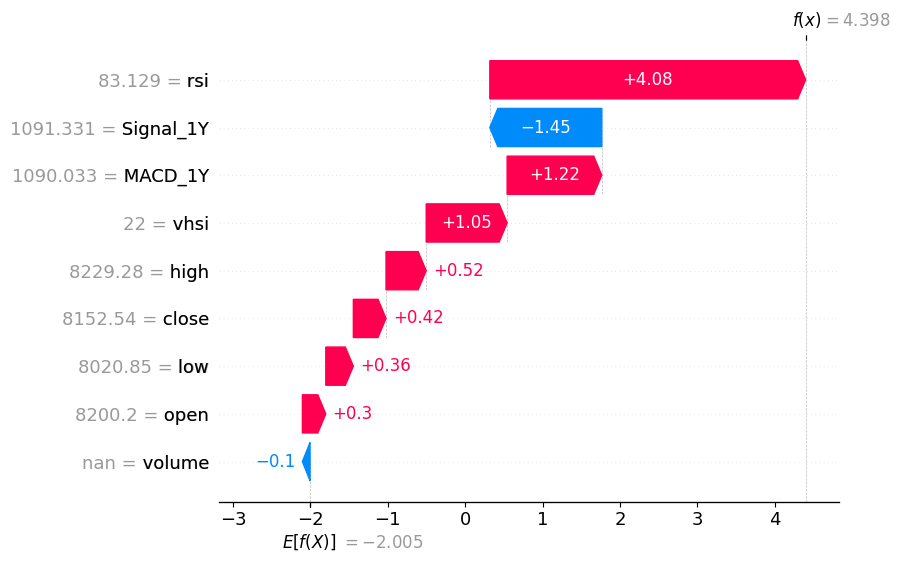

 Global feature importance (Beeswarm Plot):


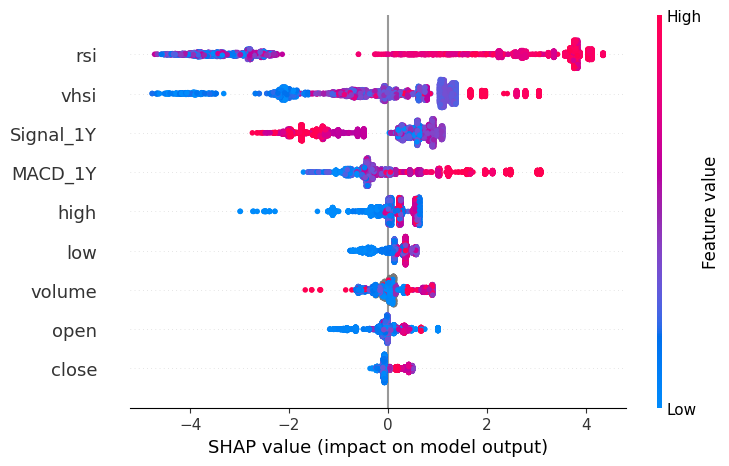

In [ ]:
import shap

# ✅ Initialize SHAP explainer for XGBoost model
explainer = shap.Explainer(model, X_train)

# ✅ Compute SHAP values (impact of each feature on each prediction)
shap_values = explainer(X_train)

# ✅ Visualize SHAP waterfall plot for a single sample (index 0)
print("🧠 Interpreting the 1st training sample (Waterfall Plot):")
shap.plots.waterfall(shap_values[0])

# ✅ Visualize global feature importance (SHAP summary / beeswarm plot)
print(" Global feature importance (Beeswarm Plot):")
shap.plots.beeswarm(shap_values)


⭐**PART 5: Train a Simplified Decision Tree for Rule Extraction**

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_text

# ✅ Train a shallow decision tree to extract simplified rules (does not affect main model)
rule_model = DecisionTreeClassifier(max_depth=3, random_state=42)
rule_model.fit(X_train, y_train)

# ✅ Export human-readable rules in if-then format
rules = export_text(rule_model, feature_names=list(X_train.columns))
print("📜 Simplified Sell Rules (Decision Tree):\n")
print(rules)


📜 Simplified Sell Rules (Decision Tree):

|--- rsi <= 70.32
|   |--- class: 0
|--- rsi >  70.32
|   |--- vhsi <= 20.05
|   |   |--- class: 0
|   |--- vhsi >  20.05
|   |   |--- close <= 3355.21
|   |   |   |--- class: 0
|   |   |--- close >  3355.21
|   |   |   |--- class: 1



⭐**PART 6: Predict Probabilities & Generate Sell Strategy Suggestions**


In [ ]:
#### ✅ Get the predicted probability for class "1" (i.e., 'sell') for each test sample
sell_prob = model.predict_proba(X_test)[:, 1]

# ✅ Attach predicted probabilities and true labels to the test set
X_test_with_prob = X_test.copy()
X_test_with_prob['sell_prob'] = sell_prob
X_test_with_prob['true_label'] = y_test.values

# ✅ Define rule-based suggestion logic based on sell probability
def signal_rule(prob):
    if prob > 0.9:
        return "🔥 Sell All"
    elif prob > 0.7:
        return "⚠️ Sell Partially"
    elif prob < 0.6:
        return "✅ Hold"
    else:
        return "🤔 Uncertain"

# ✅ Apply strategy logic
X_test_with_prob['suggestion'] = X_test_with_prob['sell_prob'].apply(signal_rule)

# ✅ Display top 10 strategy suggestions
X_test_with_prob[['sell_prob', 'true_label', 'suggestion']].head(10)


,sell_prob,true_label,suggestion
1010,0.005511,0,✅ Hold
1283,0.978635,1,🔥 Sell All
1469,0.987163,1,🔥 Sell All
1338,0.989899,1,🔥 Sell All
926,0.973055,1,🔥 Sell All
1723,0.002276,0,✅ Hold
1455,0.986312,1,🔥 Sell All
1690,0.001378,0,✅ Hold
1946,0.973126,1,🔥 Sell All
1400,0.987846,1,🔥 Sell All


In [ ]:
summary = X_test_with_prob.groupby('suggestion').agg(
    count=('sell_prob', 'count'),
    rsi_mean=('rsi', 'mean'),
    rsi_min=('rsi', 'min'),
    rsi_max=('rsi', 'max'),
    vhsi_mean=('vhsi', 'mean'),
    vhsi_min=('vhsi', 'min'),
    vhsi_max=('vhsi', 'max')
).reset_index()


⭐**PART 7: Merge Predicted Probabilities Back for Backtesting**

In [ ]:
import pandas as pd

# ✅ Step 1: Load full dataset
merged = pd.read_csv("merged_10Y_dataset.csv")
merged['date'] = pd.to_datetime(merged['date'])
merged = merged.sort_values('date').reset_index(drop=True)

# ✅ Step 2: Predict sell_prob on full dataset
features = ['rsi', 'vhsi', 'MACD_1Y', 'Signal_1Y', 'open', 'high', 'low', 'close', 'volume']
X_all = merged[features].copy()
sell_prob = model.predict_proba(X_all)[:, 1]

# ✅ Step 3: Attach sell_prob to full data
merged['sell_prob'] = sell_prob

# ✅ Step 4: Save output for backtesting
merged.to_csv("merged_with_sell_prob.csv", index=False)
print("✅ Exported successfully: merged_with_sell_prob.csv")
print("✅ 总行数：", len(merged))
print("✅ 有效 sell_prob 行数：", merged['sell_prob'].notna().sum())
print("✅ 时间区间：", merged['date'].min(), "→", merged['date'].max())


✅ Exported successfully: merged_with_sell_prob.csv
✅ 总行数： 2467
✅ 有效 sell_prob 行数： 2467
✅ 时间区间： 2015-03-02 00:00:00 → 2025-03-12 00:00:00


⭐**PART 8: Backtest Two Strategies on Timeframes**

In [ ]:
##MACD 1Y
import pandas as pd

# === Step 1: Load data ===
merged = pd.read_csv("merged_with_sell_prob.csv")
merged['date'] = pd.to_datetime(merged['date'])
merged = merged.sort_values(by='date').reset_index(drop=True)
merged['RSI'] = calculate_rsi(merged['close'])
print("✅ all lines：", len(merged))           # 看看是 1260 还是 2500+？
print("✅ Date from：", merged['date'].min(), "→", merged['date'].max())


# === Step 2: Keep valid columns and drop rows with missing sell_prob ===
merged = merged[['date', 'close', 'MACD_1Y', 'Signal_1Y', 'sell_prob', 'RSI']].dropna()


# === Step 3: Define MACD golden cross ===
def is_macd_golden_cross(df):
    return (df['MACD_1Y'].shift(1) <= df['Signal_1Y'].shift(1)) & (df['MACD_1Y'] > df['Signal_1Y'])

merged['golden_cross'] = is_macd_golden_cross(merged)
merged['buy_signal'] = merged['golden_cross'] #测试单用MACD



# === Step 4: Backtest Strategy A (track total, buy, and sell operations) ===
def backtest_strategy_a(df):
    capital = 100.0
    position = 0.0
    logs = []
    buy_count = 0
    sell_count = 0

    for i in range(1, len(df)):
        today = df.iloc[i]

        # Buy logic
        if today['buy_signal']:
        #if today['golden_cross']:
            if position == 0:
                amount = 0.5 * capital / today['close']
                capital -= amount * today['close']
                position += amount
                logs.append((today['date'], 'Initial Buy 50%', capital + position * today['close']))
                buy_count += 1
            elif capital > 0:
                amount = 0.8 * capital / today['close']
                capital -= amount * today['close']
                position += amount
                logs.append((today['date'], 'Add Buy 80%', capital + position * today['close']))
                buy_count += 1

        # Sell logic
        if today['sell_prob'] > 0.9 and position > 0:
            sell_amt = position * 0.5
            capital += sell_amt * today['close']
            position -= sell_amt
            logs.append((today['date'], 'Strong Sell 50%', capital + position * today['close']))
            sell_count += 1
        elif 0.7 < today['sell_prob'] <= 0.9 and position > 0:
            sell_amt = position * 0.3
            capital += sell_amt * today['close']
            position -= sell_amt
            logs.append((today['date'], 'Partial Sell 30%', capital + position * today['close']))
            sell_count += 1

    final_val = round(capital + position * df.iloc[-1]['close'], 2)
    return final_val, logs, len(logs), buy_count, sell_count

# === Step 5: Backtest Strategy B (buy once on first golden cross and hold) ===
def backtest_strategy_b(df):
    capital = 100.0
    position = 0.0
    for i in range(1, len(df)):
        today = df.iloc[i]
        if today['golden_cross']:
            position = capital / today['close']
            capital = 0.0
            break
    return round(capital + position * df.iloc[-1]['close'], 2)

# === Step 6: Define time windows ===
timeframes = {
    "1Y": merged.tail(252),
    "3Y": merged.tail(252*3),
    "5Y": merged.tail(252*5),
    "10Y": merged.tail(252*10)
}

# === Step 7: Run both strategies and track buy/sell operations ===
initial_capital = 100.0
results = []

period_years = {
    "1Y": 1,
    "3Y": 3,
    "5Y": 5,
    "10Y": 10
}

for label, df in timeframes.items():
    years = period_years[label]
    a_val, a_logs, total_ops, buy_ops, sell_ops = backtest_strategy_a(df)
    b_val = backtest_strategy_b(df)

    # === Annualized revenue ===
    a_cagr = (a_val / initial_capital) ** (1 / years) - 1
    b_cagr = (b_val / initial_capital) ** (1 / years) - 1

    results.append({
        "Period": label,
        "Strategy A Net Value": a_val,
        "Strategy B Net Value": b_val,
        "Strategy A Return": f"{(a_val - initial_capital):.2f}%",
        "Strategy B Return": f"{(b_val - initial_capital):.2f}%",
        "Strategy A CAGR": f"{a_cagr * 100:.2f}%",
        "Strategy B CAGR": f"{b_cagr * 100:.2f}%",
        "Excess Return": f"{(a_val - b_val):.2f}",
        "Strategy A Operation Count": total_ops,
        "Buy Count": buy_ops,
        "Sell Count": sell_ops
    })


# === Step 8: Output comparison table ===
pd.DataFrame(results)

✅ all lines： 2467
✅ Date from： 2015-03-02 00:00:00 → 2025-03-12 00:00:00


,Period,Strategy A Net Value,Strategy B Net Value,Strategy A Return,Strategy B Return,Strategy A CAGR,Strategy B CAGR,Excess Return,Strategy A Operation Count,Buy Count,Sell Count
0,1Y,160.76,162.20,60.76%,62.20%,60.76%,62.20%,-1.44,9,3,6
1,3Y,165.19,132.92,65.19%,32.92%,18.21%,9.95%,32.27,21,7,14
2,5Y,131.75,108.60,31.75%,8.60%,5.67%,1.66%,23.15,41,11,30
3,10Y,269.17,174.45,169.17%,74.45%,10.41%,5.72%,94.72,51,18,33


⭐**PART 9: Visualize portfolio and Trade Actions (Strategy A)**

<ipython-input-11-839953bc9b71>:31: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


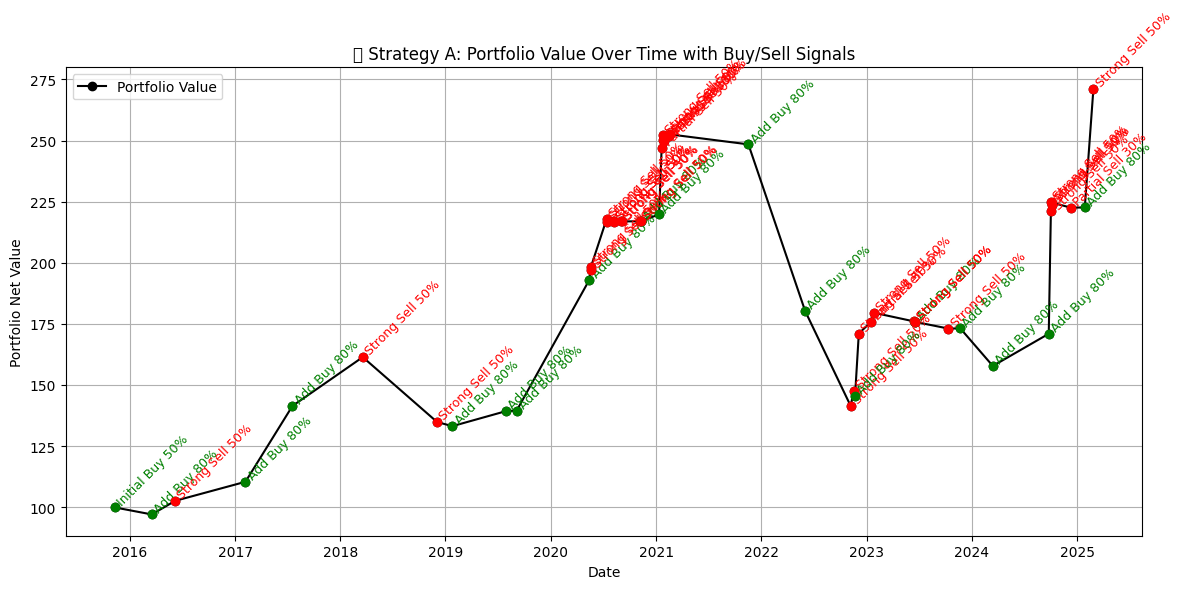

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ✅ Run Strategy A and get full results
final_val, logs, op_count, buy_count, sell_count = backtest_strategy_a(merged)

# ✅ Check if there are any logs
if not logs:
    print("⚠️ No trades were logged. Please check your strategy logic or input data.")
else:
    # ✅ Convert logs to DataFrame for safety and clarity
    log_df = pd.DataFrame(logs, columns=["date", "action", "value"])
    log_df['date'] = pd.to_datetime(log_df['date'])

    # ✅ Plot portfolio value over time
    plt.figure(figsize=(12, 6))
    plt.plot(log_df['date'], log_df['value'], marker='o', linestyle='-', label='Portfolio Value', color='black')

    # ✅ Highlight buy/sell actions
    for i, row in log_df.iterrows():
        color = 'green' if 'Buy' in row['action'] else 'red'
        plt.scatter(row['date'], row['value'], color=color, zorder=5)
        plt.text(row['date'], row['value'] + 1, row['action'], fontsize=9, rotation=45, color=color)

    # ✅ Final formatting
    plt.title('📈 Strategy A: Portfolio Value Over Time with Buy/Sell Signals')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Net Value')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


<ipython-input-12-a21f0450c961>:32: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


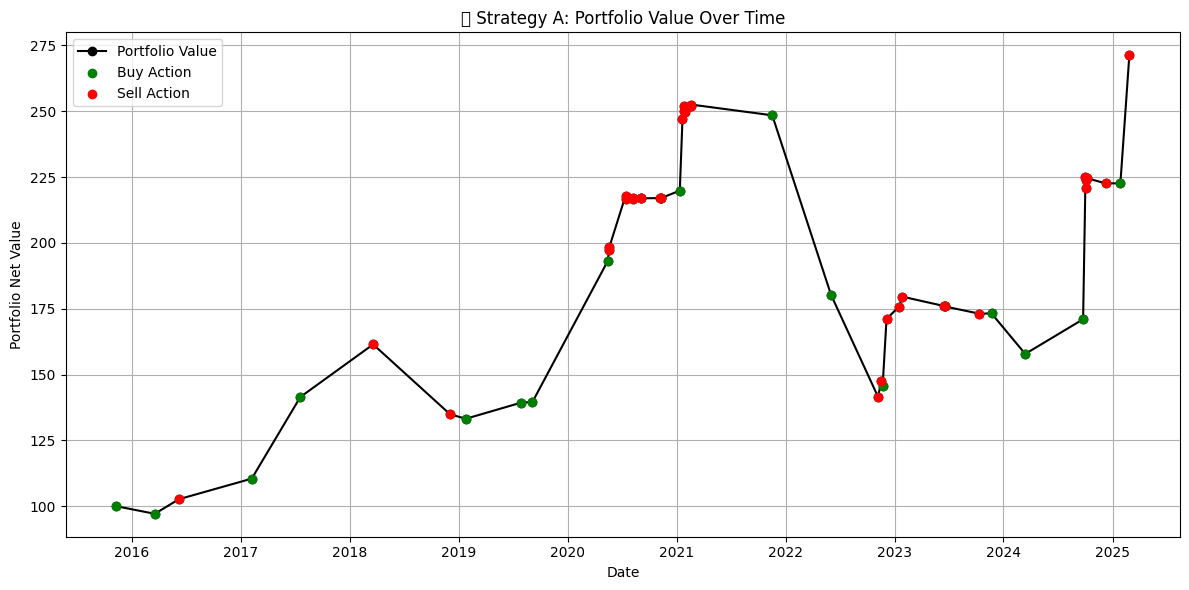

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Run strategy
final_val, logs, op_count, buy_count, sell_count = backtest_strategy_a(merged)

# Check logs
if not logs:
    print("⚠️ No trades found.")
else:
    log_df = pd.DataFrame(logs, columns=["date", "action", "value"])
    log_df['date'] = pd.to_datetime(log_df['date'])

    # Separate buy/sell actions for plotting
    buy_points = log_df[log_df['action'].str.contains("Buy")]
    sell_points = log_df[log_df['action'].str.contains("Sell")]

    # Plot portfolio value
    plt.figure(figsize=(12, 6))
    plt.plot(log_df['date'], log_df['value'], marker='o', linestyle='-', color='black', label='Portfolio Value')

    # Plot buy and sell points with color only (no text)
    plt.scatter(buy_points['date'], buy_points['value'], color='green', label='Buy Action', zorder=5)
    plt.scatter(sell_points['date'], sell_points['value'], color='red', label='Sell Action', zorder=5)

    # Labels and formatting
    plt.title('📈 Strategy A: Portfolio Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Net Value')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


图

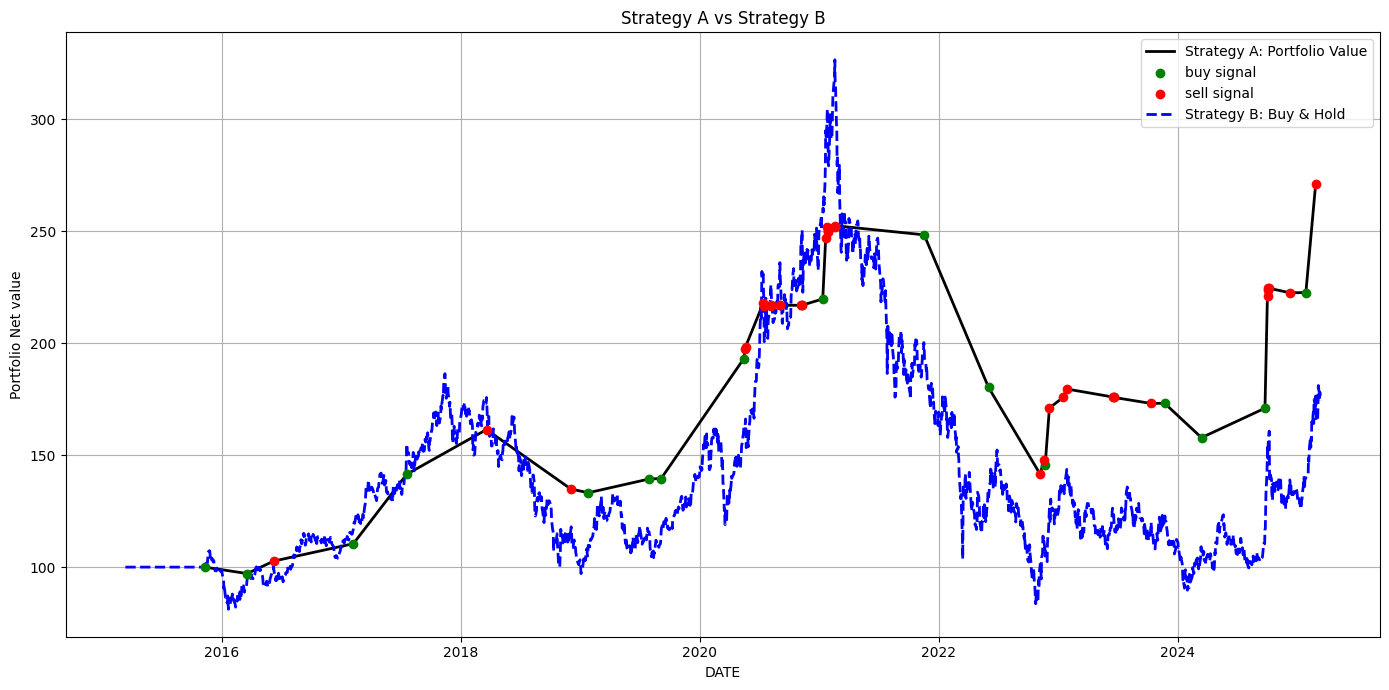

<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 运行 Strategy A 并记录所有交易日志
final_val_a, logs_a, op_count_a, buy_count_a, sell_count_a = backtest_strategy_a(merged)

# 运行 Strategy B 并记录最终净值
final_val_b = backtest_strategy_b(merged)
logs_b = [(merged.iloc[-1]['date'], 'Hold', final_val_b)]  # Strategy B 只有最后一天有净值

# 将 Strategy A 的日志转换为 DataFrame
if not logs_a:
    print("⚠️ Strategy A 没有产生任何交易")
else:
    log_df_a = pd.DataFrame(logs_a, columns=["date", "action", "value"])
    log_df_a['date'] = pd.to_datetime(log_df_a['date'])

# 将 Strategy B 的日志也转成 DataFrame
log_df_b = pd.DataFrame(logs_b, columns=["date", "action", "value"])
log_df_b['date'] = pd.to_datetime(log_df_b['date'])

# 绘图：将两个策略画在同一个图表中
plt.figure(figsize=(14, 7))

# === Strategy A 的净值曲线 + 买卖点 ===
plt.plot(log_df_a['date'], log_df_a['value'], label='Strategy A: Portfolio Value', color='black', linewidth=2)

buy_points = log_df_a[log_df_a['action'].str.contains('Buy')]
sell_points = log_df_a[log_df_a['action'].str.contains('Sell')]

plt.scatter(buy_points['date'], buy_points['value'], color='green', label='buy signal', zorder=5)
plt.scatter(sell_points['date'], sell_points['value'], color='red', label='sell signal', zorder=5)

# === Strategy B 的净值曲线（只一个点？或者你可以补全每天的持仓价值）===
# 如果 Strategy B 只买了不卖，我们可以计算每一天的价值来画整条线
strategy_b_values = []
capital_b = 100.0
position_b = 0.0
bought = False

for i in range(len(merged)):
    row = merged.iloc[i]
    if not bought and row['golden_cross']:
        position_b = capital_b / row['close']
        capital_b = 0
        bought = True
    current_value = capital_b + position_b * row['close']
    strategy_b_values.append((row['date'], current_value))

log_df_b_full = pd.DataFrame(strategy_b_values, columns=['date', 'value'])
plt.plot(log_df_b_full['date'], log_df_b_full['value'], label='Strategy B: Buy & Hold', linestyle='--', color='blue', linewidth=2)

# 设置图表样式
plt.title('Strategy A vs Strategy B')
plt.xlabel('DATE')
plt.ylabel('Portfolio Net value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig("strategy_comparison.png")

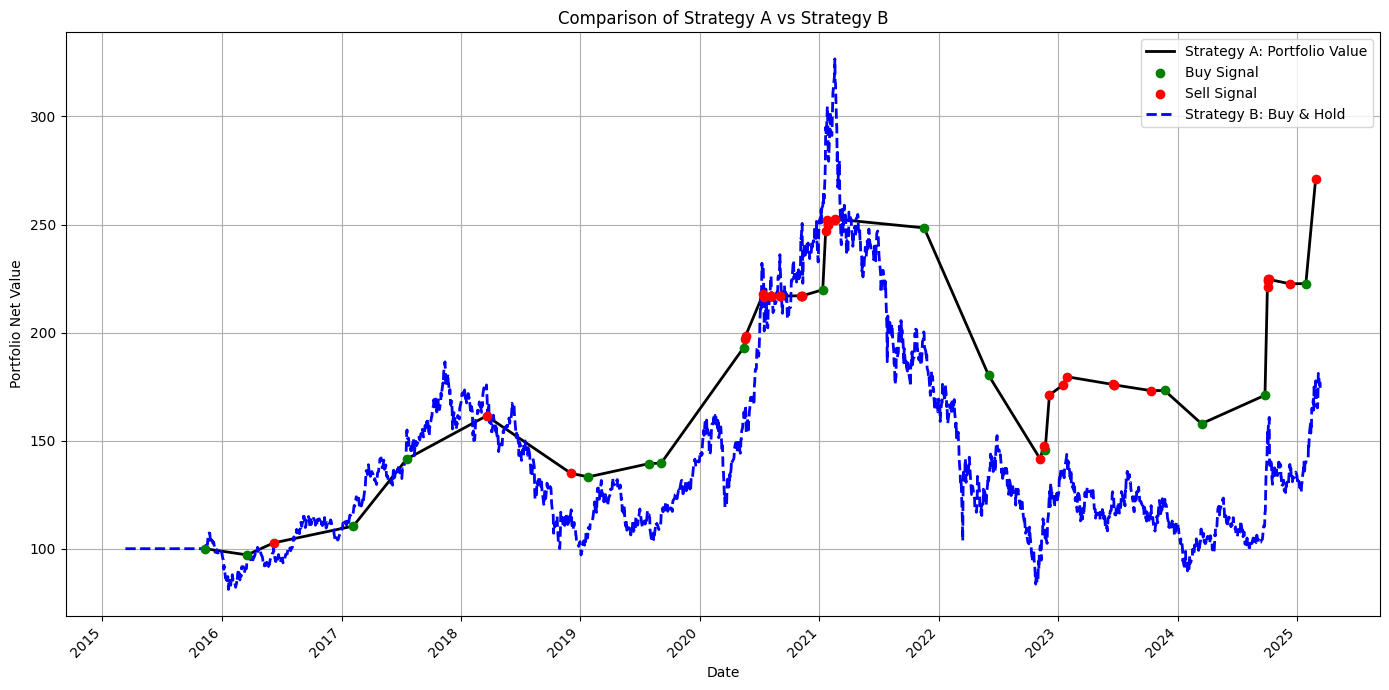

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 运行 Strategy A 并记录所有交易日志
final_val_a, logs_a, op_count_a, buy_count_a, sell_count_a = backtest_strategy_a(merged)

# 运行 Strategy B 并记录最终净值
final_val_b = backtest_strategy_b(merged)
logs_b = [(merged.iloc[-1]['date'], 'Hold', final_val_b)]  # Strategy B 只有最后一天有净值

# 将 Strategy A 的日志转换为 DataFrame
if not logs_a:
    print("⚠️ No trades found for Strategy A.")
else:
    log_df_a = pd.DataFrame(logs_a, columns=["date", "action", "value"])
    log_df_a['date'] = pd.to_datetime(log_df_a['date'])

# 将 Strategy B 的日志也转成 DataFrame
log_df_b = pd.DataFrame(logs_b, columns=["date", "action", "value"])
log_df_b['date'] = pd.to_datetime(log_df_b['date'])

# 绘图：将两个策略画在同一个图表中
plt.figure(figsize=(14, 7))

# === Strategy A 的净值曲线 + 买卖点 ===
plt.plot(log_df_a['date'], log_df_a['value'], label='Strategy A: Portfolio Value', color='black', linewidth=2)

buy_points = log_df_a[log_df_a['action'].str.contains('Buy')]
sell_points = log_df_a[log_df_a['action'].str.contains('Sell')]

plt.scatter(buy_points['date'], buy_points['value'], color='green', label='Buy Signal', zorder=5)
plt.scatter(sell_points['date'], sell_points['value'], color='red', label='Sell Signal', zorder=5)

# === Strategy B 的净值曲线（只一个点？或者你可以补全每天的持仓价值）===
# 如果 Strategy B 只买了不卖，我们可以计算每一天的价值来画整条线
strategy_b_values = []
capital_b = 100.0
position_b = 0.0
bought = False

for i in range(len(merged)):
    row = merged.iloc[i]
    if not bought and row['golden_cross']:
        position_b = capital_b / row['close']
        capital_b = 0
        bought = True
    current_value = capital_b + position_b * row['close']
    strategy_b_values.append((row['date'], current_value))

log_df_b_full = pd.DataFrame(strategy_b_values, columns=['date', 'value'])
plt.plot(log_df_b_full['date'], log_df_b_full['value'], label='Strategy B: Buy & Hold', linestyle='--', color='blue', linewidth=2)

# 设置图表样式
plt.title('Comparison of Strategy A vs Strategy B')
plt.xlabel('Date')
plt.ylabel('Portfolio Net Value')
plt.legend()

# === 调整横坐标（日期轴） ===
# 设置每年显示一个刻度
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
# 格式化日期为年份（如 2016、2017）
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
# 旋转 x 轴标签，避免重叠
plt.gcf().autofmt_xdate(rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()